In [165]:
import requests
from datetime import timezone, timedelta
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks, find_peaks_cwt

In [222]:
# we want to get a day's worth of crypto data from coingecko at a specified interval

CURRENCY = 'btc'

# use pre-acquired coin id data
ids = pd.read_csv("cg_coin_ids.csv")
coin_id = ids[ids['symbol'] == CURRENCY]['id'].values[0]

res = requests.get(f'https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart?vs_currency=usd&days=1')
res.raise_for_status()

coin_data = res.json()
unzipped = list(zip(*coin_data['prices']))
prices_raw = pd.DataFrame({'ms_datetime': unzipped[0], 'price': unzipped[1]})

In [251]:
# format dataset time
prices_raw['date_time'] = pd.to_datetime(prices_raw['ms_datetime'], unit='ms', utc=True)
prices = prices_raw[['date_time', 'price']].copy()
prices['local_dt'] = prices['date_time'].dt.tz_convert(timezone(-timedelta(hours=6)))
prices = prices.sort_values(by='local_dt')[['local_dt', 'price']]

# cut down to 15-minute intervals
prices['fifteen_min'] = np.tile(range(1, 4), prices.shape[0]//3 + 1)[:prices.shape[0]]
prices['fifteen_min'] = prices['fifteen_min'] == 1
m15 = prices[prices['fifteen_min']].reset_index(drop=True)
m15 = m15[['local_dt', 'price']]

# add moving average
ma_period = 4
m15['ma'] = m15['price'].rolling(ma_period).mean()

# add rsi
periods = 14
m15['price_change'] = m15['price'].diff()
m15['pos_pc'] = m15['price_change'].apply(lambda x: x if x > 0 else 0)
m15['neg_pc'] = m15['price_change'].apply(lambda x: abs(x) if x < 0 else 0)

m15['avg_gain'] = m15['pos_pc'].rolling(periods).mean()
m15['avg_loss'] = m15['neg_pc'].rolling(periods).mean()
m15['rs'] = m15['avg_gain'] / m15['avg_loss']
m15['rsi'] = 100 - (100 / (1 + m15['rs']))

# get inflection points
# m15['second_derivative'] = m15['ma'].diff().diff()
# inflection_points = m15[m15['second_derivative'].diff().fillna(0).ne(0)].index
poly_order = 3

# apply low-pass filter to reduce inflection point detection sensitivity
ma_smoothed = savgol_filter(m15['ma'], ma_period, poly_order)
ma_smoothed_2d = np.gradient(np.gradient(ma_smoothed))
ipoints_raw = np.diff(np.sign(ma_smoothed_2d))
np.put(ipoints_raw, np.where(np.isnan(ipoints_raw)), 0)
inflection_points = np.where(ipoints_raw)[0] + 1
m15['is_inflection'] = m15.index.isin(inflection_points)
m15['inflection_price'] = m15.apply(lambda x: x['price'] if x['is_inflection'] else np.nan, axis=1)

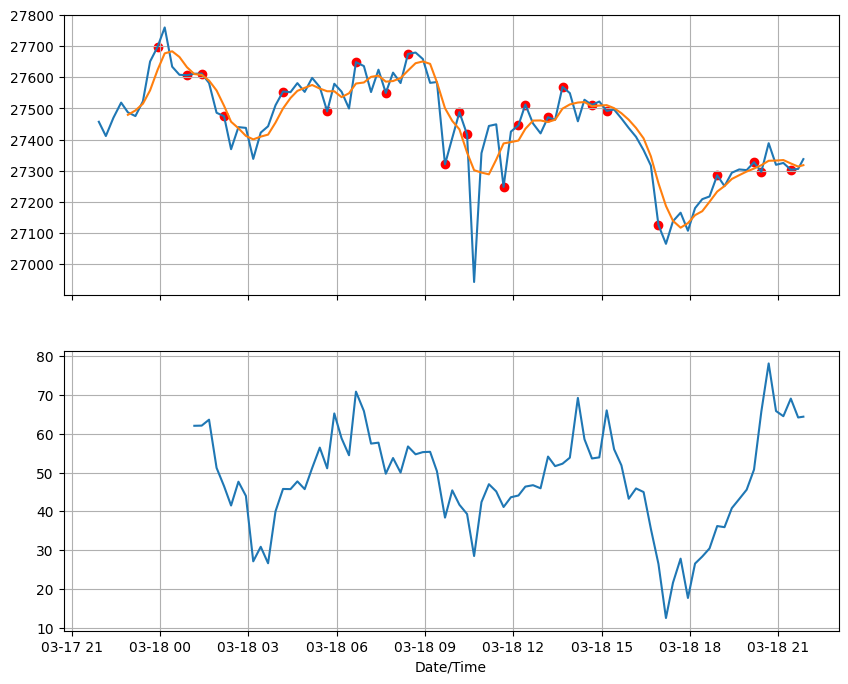

In [252]:
# plot price, moving average and rsi
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)


ax1.plot(m15['local_dt'], m15['price'])
ax1.plot(m15['local_dt'], ma_smoothed)
ax1.scatter(m15['local_dt'], m15['inflection_price'], color='red')
ax1.grid(True)

ax2.plot(m15['local_dt'], m15['rsi'])
ax2.grid(True)
ax2.set_xlabel('Date/Time')

plt.show()